Target:

Add Regularization Dropout to each layer except last layer.

Results:



*   Parameters: 5,088
*   Best Train Accuracy: 97.94%
*   Best Test Accuracy: 98.64%

Analysis:
* There is no overfitting at all. With dropout training will be harder, because we are droping the pixels randomly.
* The performance has droppped, we can further improve it.
* But with the current capacity,not possible to push it further.We can possibly increase the capacity of the model by adding a layer after GAP!



.

# Import Libraries

Let's first import all the necessary libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# Defining Model
 Create a CNN Model Skeleton

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=0,bias=False),  # 28x28 output 28x28 RF : 3x3
            nn.BatchNorm2d(8),
            nn.Dropout(0.10),
            nn.ReLU(),

            nn.Conv2d(8, 16, 3,padding=0,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU(),

                    
        )

        #Transition Block 
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            # 1x1 convolution
            nn.Conv2d(16, 8, 1,bias=False), # 26x26 output - 26x26 RF 14x14
            nn.BatchNorm2d(8),
            nn.Dropout(0.10),
            nn.ReLU(),

              # 26x26 output - 13x13 RF 14x14

        )

        #CONVOLUTION BLOCK 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 10, 3,padding=0, bias=False), # 13x13 output - 11x11 RF 16x16
            nn.BatchNorm2d(10),
            nn.Dropout(0.10),
            nn.ReLU(),

            nn.Conv2d(10, 16, 3,padding=0, bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.BatchNorm2d(16),
            nn.Dropout(0.10),
            nn.ReLU(),

            nn.Conv2d(16, 10, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.BatchNorm2d(10),
            nn.Dropout(0.10),
            nn.ReLU(),

            
            
        )
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        #x = self.conv3(x)
        x = x.view(-1,10)

        return F.log_softmax(x,dim=1)

# Model Summary
 To view and to understand Model Trainable parameteres

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
              ReLU-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
          Dropout-12            [-1, 8, 12, 12]               0
             ReLU-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 10,

# The Model


In [ ]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.1, inplace=False)
    (7): ReLU()
  )
  (trans1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=Fal

## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)



Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training & Testing Functions
 Creating Training and Testing functions.

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test our Model
 Let's train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3414463698863983 Batch_id=468 Accuracy=82.95: 100%|██████████| 469/469 [00:12<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2619, Accuracy: 9551/10000 (95.51%)

EPOCH: 1


Loss=0.18882876634597778 Batch_id=468 Accuracy=95.19: 100%|██████████| 469/469 [00:12<00:00, 38.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1504, Accuracy: 9701/10000 (97.01%)

EPOCH: 2


Loss=0.1350458711385727 Batch_id=468 Accuracy=96.21: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1161, Accuracy: 9709/10000 (97.09%)

EPOCH: 3


Loss=0.11485239863395691 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:12<00:00, 38.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9795/10000 (97.95%)

EPOCH: 4


Loss=0.08376205712556839 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:12<00:00, 37.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0718, Accuracy: 9826/10000 (98.26%)

EPOCH: 5


Loss=0.05696769058704376 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9820/10000 (98.20%)

EPOCH: 6


Loss=0.18832296133041382 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9828/10000 (98.28%)

EPOCH: 7


Loss=0.09366878867149353 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:12<00:00, 36.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0520, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.07870972901582718 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:12<00:00, 37.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9820/10000 (98.20%)

EPOCH: 9


Loss=0.09167354553937912 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:12<00:00, 37.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9853/10000 (98.53%)

EPOCH: 10


Loss=0.08681618422269821 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9870/10000 (98.70%)

EPOCH: 11


Loss=0.09773895144462585 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9876/10000 (98.76%)

EPOCH: 12


Loss=0.08756499737501144 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:12<00:00, 37.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9865/10000 (98.65%)

EPOCH: 13


Loss=0.11765307188034058 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:12<00:00, 37.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9876/10000 (98.76%)

EPOCH: 14


Loss=0.12900766730308533 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]



Test set: Average loss: 0.0471, Accuracy: 9864/10000 (98.64%)



Text(0.5, 1.0, 'Test Accuracy')

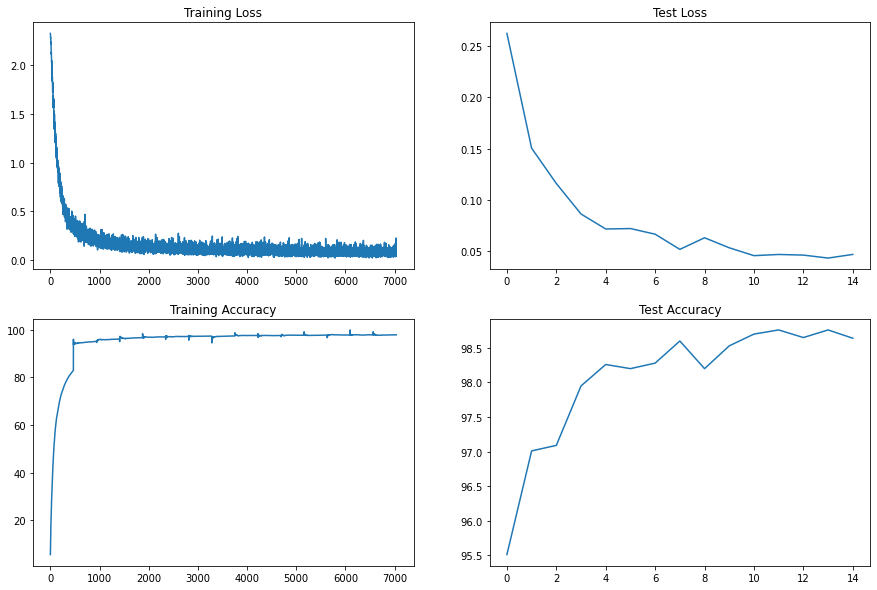

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")